# Image classfication with Convolutional Neural Networks

## Import libraries

Run and setup if you are going to run this in Colab

In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')
# Change this path to your Project Drive data folder. It is one level under the root project folder
os.chdir('/content/drive/MyDrive/code/AI4SG/Course3/W3/data')

Mounted at /content/drive


If training in Colab, it is better to unzip the files into the project mounted folder each time, else, it will take a long time training. So, first remove any existing data.


In [4]:
! rm -rf ./train*
! rm -rf ./test*
! rm -rf ./validation*



In [ ]:
Now, unzip the original dataset

In [ ]:
!unzip -o post-hurricane.zip


Rename the folders to get the right classes to label mapping.

In [6]:
!mv train_another/damage train_another/visible_damage
!mv validation_another/damage validation_another/visible_damage
!mv test_another/damage test_another/visible_damage
!mv test/damage test/visible_damage

!ls train_another/

Now, move to the root project folder

In [8]:
os.chdir('/content/drive/MyDrive/code/AI4SG/Course3/W3/')

## Import required libraries

In [9]:
import keras
import h5py
import PIL.Image
import os, shutil
import pickle

import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import layers, models, Sequential, optimizers
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LeakyReLU
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt

from utils import leaflet_plot

print(tf. __version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


## Load the data

We have divided the dataset into 3 parts: Train, validation and test. 

In [12]:
original_dataset_dir = './data'

train_damage_dir = original_dataset_dir + '/train_another/visible_damage'
validation_damage_dir = original_dataset_dir + '/validation_another/visible_damage'
test_damage_dir = original_dataset_dir + '/test/visible_damage'

train_nodamage_dir = original_dataset_dir + '/train_another/no_damage'
validation_nodamage_dir = original_dataset_dir + '/validation_another/no_damage'
test_nodamage_dir = original_dataset_dir + '/test/no_damage'

print('total training damage images: ',len(os.listdir(train_damage_dir)))
print('total validation damage images: ',len(os.listdir(validation_damage_dir)))
print('total test damage images: ',len(os.listdir(test_damage_dir)))

print('total training no damage images: ',len(os.listdir(train_nodamage_dir)))
print('total validation no damage images: ',len(os.listdir(validation_nodamage_dir)))
print('total test no damage images: ',len(os.listdir(test_nodamage_dir)))

Check that data is ok. Print amount of visible damage vs no damage data into train dataset. 



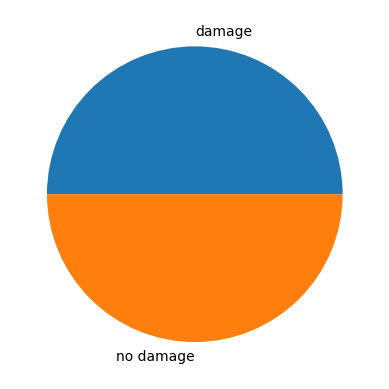

In [14]:
plt.pie( [len(os.listdir(train_damage_dir)), len(os.listdir(train_nodamage_dir))], None, ['damage', 'no damage'])
plt.show()

Let's use an ImageDataGenerator. A Data Generator allows to train models without loading the whole dataset into memory. During the training process the model will load batches of data into memory. 

In [15]:
#train using data augmentation and dropout
train_datagen = ImageDataGenerator(
                    rescale = 1./255,
                    brightness_range=(0.5, 1.5),
                    rotation_range = 30,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255) #validation data should not be augmented

train_generator = train_datagen.flow_from_directory(original_dataset_dir +
                    '/train_another', 
                    target_size = (150,150),
                    batch_size = 32,
                    class_mode = 'binary')
validation_generator = test_datagen.flow_from_directory(original_dataset_dir +
                    '/validation_another', 
                    target_size = (150,150),
                    batch_size = 32,
                    class_mode = 'binary')

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


Print class to label mapping

In [16]:
validation_generator.class_indices

{'no_damage': 0, 'visible_damage': 1}

In [42]:
continue_training = False
epochs = 100

model = models.Sequential()
model.add(layers.Conv2D(32,(3,3), activation = 'relu', input_shape = (150, 150, 3), kernel_regularizer=l2(0.0005)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(64,(3,3), activation = 'relu', kernel_regularizer=l2(0.0005)))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(128,(3,3), activation = 'relu', kernel_regularizer=l2(0.0005)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.1))
#
model.add(layers.Conv2D(128,(3,3), activation = 'relu', kernel_regularizer=l2(0.0005)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.1))

model.add(layers.Flatten())
model.add(layers.Dropout(0.1))
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))
#compile the model with RMSprob with learning rate

adam = Adam(learning_rate=0.00003)
model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])

# Set early-stopping criterion based on the accuracy on the development set with the patience of 10
early_stopping = EarlyStopping(monitor="val_accuracy", patience=10, verbose=1, mode="max")
# Initialize TensorBoard to visualize learning
tensorboard = TensorBoard(log_dir=f"models/cnn_100epochs_Adam", write_images=True)
# Create model checkpoints
checkpoint_filepath = f"models/cnn_checkpoint2"
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor="val_accuracy", save_best_only=True, save_weights_only=True, mode="max")
if continue_training:
  model.load_weights(checkpoint_filepath)

# Train and validate model
history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=50,
                    callbacks=[tensorboard, checkpoint])

# Load model with best weights
model.load_weights(checkpoint_filepath)

# Save trained model with best weights
model.save(f"models/cnn_100epochs_Adam.hdf5")

with open('/cnn_history', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)


Epoch 1/100
100/100 [==============================] - 37s 345ms/step - loss: 0.7692 - accuracy: 0.6150 - val_loss: 0.8132 - val_accuracy: 0.5744
Epoch 2/100
100/100 [==============================] - 32s 325ms/step - loss: 0.6453 - accuracy: 0.7601 - val_loss: 0.7620 - val_accuracy: 0.6856
Epoch 3/100
100/100 [==============================] - 32s 316ms/step - loss: 0.5743 - accuracy: 0.8056 - val_loss: 0.6950 - val_accuracy: 0.8181
Epoch 4/100
100/100 [==============================] - 32s 323ms/step - loss: 0.5356 - accuracy: 0.8398 - val_loss: 0.6145 - val_accuracy: 0.8512
Epoch 5/100
100/100 [==============================] - 32s 316ms/step - loss: 0.5213 - accuracy: 0.8509 - val_loss: 0.5544 - val_accuracy: 0.8413
Epoch 6/100
100/100 [==============================] - 32s 325ms/step - loss: 0.4956 - accuracy: 0.8522 - val_loss: 0.4763 - val_accuracy: 0.8731
Epoch 7/100
100/100 [==============================] - 33s 335ms/step - loss: 0.4702 - accuracy: 0.8628 - val_loss: 0.4381 -

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255, vertical_flip=True, horizontal_flip=True, brightness_range=(0.5, 1.5)) 

test_generator = test_datagen.flow_from_directory(original_dataset_dir +
                    '/test', 
                    target_size = (150,150),
                    batch_size = 32,
                    class_mode = 'binary')

loss, acc = model.evaluate(test_generator, steps=2000, verbose=0)
print(loss)

Found 2000 images belonging to 2 classes.


0.1866864562034607


In [ ]:
acc

0.9624999761581421

In [ ]:
acc

0.9595000147819519